# SQL vs Pandas for Energy Data

In this section we will cover a step-by-step example to integrate the energy production data stored in a database (SQLite) and then using Python to analyze and plot the data. This guide walks through each step, from loading CSV data into an SQLite database to querying and plotting the energy production data for different countries.

This sections includes downloading the data from individual `.csv` files, loading them into a SQLite database, and visualizing the energy production using Python.

This guide shows how to:
1. Download CSV files from Eurostat.
2. Load data into a SQLite database.
3. Use Python to query and visualize the data.

## Step 1: Download the Data from Eurostat

The datasets are available on the Eurostat website under [Energy Statistics](https://ec.europa.eu/eurostat/web/energy). Let’s assume the data files have been downloaded and stored in your `~/Downloads` folder as `.csv` files.

For this example, we are using the following datasets:

In [52]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt

In [2]:
file_paths = {
    'coal': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_coal.xlsx',
    'nonRenewables': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_combustionFuels_nonRenewables.xlsx',
    'renewables': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_combustionFuels_Renewables.xlsx',
    'geothermal': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_geothermal.xlsx',
    'hydro': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_hydro.xlsx',
    'naturalGas': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_naturalGas.xlsx',
    'nuclear': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_nuclear.xlsx',
    'oil': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_oil.xlsx',
    'otherRenewables': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_otherRenewables.xlsx',
    'solar': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_solar.xlsx',
    'wind': '../data/section4/euroStat/nrg_cb_pem_page_spreadsheet_wind.xlsx'
}

In [3]:
# Connect to SQLite database (it will be created if it doesn't exist)
db_path = 'coal_energy_data.db'

#### Step 1: Check and Create the SQLite Database

Before beginning, the code checks if the SQLite database (coal_energy_data.db) already exists. If it does, the existing database file is deleted to ensure you are working with a fresh database.

In [4]:
# Check if the database file exists
if os.path.exists(db_path):
    print(f"Database {db_path} already exists. Deleting it...")
    os.remove(db_path)  # Delete the existing database file
    print(f"Database {db_path} has been deleted.")

Database coal_energy_data.db already exists. Deleting it...
Database coal_energy_data.db has been deleted.


In [5]:
# Now create a new SQLite connection
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

Afterward, the database is recreated by establishing a connection to the SQLite file.

#### Step 2: Load Data from Excel into SQLite

The coal energy data is loaded from an Excel file into a Pandas DataFrame. The raw data is then stored in the SQLite database as the initial step.

In [6]:
# Load the coal dataset
euroStat_coal = pd.read_excel(file_paths['coal'], sheet_name='coal', skiprows=range(0, 8))

In [7]:
# Store the raw data in the SQLite database
euroStat_coal.to_sql('euroStat_coal', conn, if_exists='replace', index=False)

50

#### Step 3: Remove the First Two Rows

Since the first two rows contain irrelevant information, such as metadata or unnecessary headers, they are removed using an SQL DELETE operation based on ROWID.

In [8]:
# Remove the first two rows (index 0 and 1)
cursor.execute("DELETE FROM euroStat_coal WHERE ROWID IN (1, 2);")
conn.commit()

#### Step 4: Drop Unnecessary Columns

Some columns in the data may have names starting with 'Unnamed', which indicate they are placeholders. Since SQLite does not directly support dropping columns, the workflow selects only the necessary columns and recreates a new table.

In [9]:
# Drop columns where the name starts with 'Unnamed'
cursor.execute("PRAGMA table_info(euroStat_coal);")
columns_info = cursor.fetchall()
columns_to_keep = [col[1] for col in columns_info if not col[1].startswith('Unnamed')]

In [10]:
# Create a new table with only the required columns
cursor.execute(f"""
    CREATE TABLE euroStat_coal_cleaned_v2 AS
    SELECT {', '.join(columns_to_keep)}
    FROM euroStat_coal;
""")
cursor.execute("DROP TABLE euroStat_coal;")
conn.commit()

#### Step 5: Replace Invalid Values

The data contains invalid values (:), which are replaced with NULL values in SQL. This ensures that the dataset is clean for further analysis.

In [11]:
# Replace invalid values (':' -> NULL)
for column in columns_to_keep[1:]:  # Skip 'Country' column
    cursor.execute(f"""
        UPDATE euroStat_coal_cleaned_v2
        SET "{column}" = NULLIF("{column}", ':');
    """)
conn.commit()

#### Step 6: Rename Columns to Date Format

The column names are updated to represent proper dates (e.g., 2016-01, 2016-02, etc.). If the "Country" column does not exist in the cleaned table, it is added, and the final cleaned table is created with the new date-based column names.

In [12]:
# Rename columns with date formats (2016-01, 2016-02, ... , 2024-07)
date_columns = pd.date_range(start='2016-01', end='2024-07', freq='MS').strftime('%Y-%m').tolist()

# Ensure the columns_to_keep matches the new date columns
new_columns = ['Country'] + date_columns

# Check if "Country" column exists in the cleaned table
cursor.execute("PRAGMA table_info(euroStat_coal_cleaned_v2);")
columns_info = cursor.fetchall()
if "Country" not in [col[1] for col in columns_info]:
    print("Adding 'Country' column.")
    # Recreate the table with the 'Country' column
    cursor.execute("""
        CREATE TABLE euroStat_coal_cleaned_temp AS
        SELECT "TIME" AS Country, * FROM euroStat_coal_cleaned_v2;
    """)
    cursor.execute("DROP TABLE euroStat_coal_cleaned_v2;")
    cursor.execute("""
        CREATE TABLE euroStat_coal_cleaned_v2 AS
        SELECT Country, * FROM euroStat_coal_cleaned_temp;
    """)
    cursor.execute("DROP TABLE euroStat_coal_cleaned_temp;")
conn.commit()

Adding 'Country' column.


In [13]:
# Rename columns by recreating the table with the updated date-based column names
cursor.execute(f"""
    CREATE TABLE euroStat_coal_cleaned_final AS
    SELECT Country, {', '.join([f'"{old_col}" AS "{new_col}"' for old_col, new_col in zip(columns_to_keep[1:], date_columns)])}
    FROM euroStat_coal_cleaned_v2;
""")

In [14]:
# Drop the intermediate table and rename the final table back to the original cleaned table
cursor.execute("DROP TABLE euroStat_coal_cleaned_v2;")
cursor.execute("ALTER TABLE euroStat_coal_cleaned_final RENAME TO euroStat_coal;")
conn.commit()

#### Step 7: Query and Verify Data

Finally, the cleaned data is queried to verify that the transformations have been applied correctly. The first few rows of the cleaned data are displayed.

In [15]:
# Query the cleaned data
df_coal_cleaned = pd.read_sql_query("SELECT * FROM euroStat_coal LIMIT 5;", conn)
print(df_coal_cleaned)

    Country  2016-01  2016-02  2016-03  2016-04  2016-05  2016-06  2016-07  \
0   Belgium     2015     2014     2013     2012     2011     2010     2009   
1  Bulgaria     2015     2014     2013     2012     2011     2010     2009   
2   Czechia     2015     2014     2013     2012     2011     2010     2009   
3   Denmark     2015     2014     2013     2012     2011     2010     2009   
4   Germany     2015     2014     2013     2012     2011     2010     2009   

   2016-08  2016-09  ...  2023-10  2023-11  2023-12  2024-01  2024-02  \
0     2008     2007  ...     2013     2012     2011     2023     2022   
1     2008     2007  ...     2013     2012     2011     2023     2022   
2     2008     2007  ...     2013     2012     2011     2023     2022   
3     2008     2007  ...     2013     2012     2011     2023     2022   
4     2008     2007  ...     2013     2012     2011     2023     2022   

   2024-03  2024-04  2024-05  2024-06  2024-07  
0     2021     2020     2019     2018     2

#### Step 8: Close the SQLite Connection

Once all operations are complete, the SQLite connection is closed.

In [16]:
# Close the connection
conn.close()

## Workflow Summary

1.	Check and Create the SQLite Database:
•	The code first checks if the SQLite database already exists. If it does, the existing database is deleted to ensure a fresh start.
2.	Load Data from Excel into SQLite:
•	The coal energy data is loaded from an Excel file into a Pandas DataFrame and stored in the SQLite database.
3.	Remove the First Two Rows:
•	The first two rows of the dataset, which contain irrelevant information, are removed using SQL commands based on ROWID.
4.	Drop Unnecessary Columns:
•	Columns whose names start with ‘Unnamed’ are considered unnecessary and are removed. A new table is created with only the required columns.
5.	Replace Invalid Values:
•	Invalid values represented by ‘:’ are replaced with NULL to clean the data.
6.	Rename Columns to Date Format:
•	The column names are updated to reflect proper date formats (e.g., 2016-01, 2016-02), and if the Country column is missing, it is added.
7.	Query and Verify Data:
•	The cleaned data is queried from the SQLite database to ensure the transformations have been applied correctly.
8.	Close the SQLite Connection:
•	The connection to the SQLite database is closed once all operations are complete.


---

## Repeat for all datasets

### Individual databases

In [17]:
def process_energy_data_individual_db(file_paths):
    """
    This function processes the energy production data for multiple datasets (coal, geothermal, wind, etc.)
    by loading data from Excel, cleaning it, and saving it to individual SQLite databases.
    
    Parameters:
    - file_paths: Dictionary containing dataset names and file paths.
    """
    
    for dataset, file_path in file_paths.items():
        db_name = f'{dataset}_energy_data.db'  # Create a separate DB for each dataset
        
        # Step 1: Check if the database file exists, delete if it does
        if os.path.exists(db_name):
            print(f"Database {db_name} already exists. Deleting it...")
            os.remove(db_name)  # Delete the existing database file
            print(f"Database {db_name} has been deleted.")
        
        # Now create a new SQLite connection for this dataset
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()
        
        print(f"Processing dataset: {dataset}")
        
        # Step 2: Load data from Excel
        data = pd.read_excel(file_path, sheet_name=dataset, skiprows=range(0, 8))
        
        # Step 3: Store the raw data in the SQLite database
        data.to_sql(f'{dataset}', conn, if_exists='replace', index=False)
        
        # Step 4: Remove the first two rows
        cursor.execute(f"DELETE FROM {dataset} WHERE ROWID IN (1, 2);")
        conn.commit()
        
        # Step 5: Drop columns where the name starts with 'Unnamed'
        cursor.execute(f"PRAGMA table_info({dataset});")
        columns_info = cursor.fetchall()
        columns_to_keep = [col[1] for col in columns_info if not col[1].startswith('Unnamed')]
        
        # Create a new table with only the required columns
        cursor.execute(f"""
            CREATE TABLE {dataset}_cleaned_v2 AS
            SELECT {', '.join(columns_to_keep)}
            FROM {dataset};
        """)
        cursor.execute(f"DROP TABLE {dataset};")
        conn.commit()
        
        # Step 6: Replace invalid values (':' -> NULL)
        for column in columns_to_keep[1:]:  # Skip 'Country' column
            cursor.execute(f"""
                UPDATE {dataset}_cleaned_v2
                SET "{column}" = NULLIF("{column}", ':');
            """)
        conn.commit()
        
        # Step 7: Rename columns with date formats (2016-01, 2016-02, ..., 2024-07)
        date_columns = pd.date_range(start='2016-01', end='2024-07', freq='MS').strftime('%Y-%m').tolist()
        
        # Ensure the columns_to_keep matches the new date columns
        new_columns = ['Country'] + date_columns
        
        # Check if "Country" column exists in the cleaned table
        cursor.execute(f"PRAGMA table_info({dataset}_cleaned_v2);")
        columns_info = cursor.fetchall()
        if "Country" not in [col[1] for col in columns_info]:
            print("Adding 'Country' column.")
            # Recreate the table with the 'Country' column
            cursor.execute(f"""
                CREATE TABLE {dataset}_cleaned_temp AS
                SELECT "TIME" AS Country, * FROM {dataset}_cleaned_v2;
            """)
            cursor.execute(f"DROP TABLE {dataset}_cleaned_v2;")
            cursor.execute(f"""
                CREATE TABLE {dataset}_cleaned_v2 AS
                SELECT Country, * FROM {dataset}_cleaned_temp;
            """)
            cursor.execute(f"DROP TABLE {dataset}_cleaned_temp;")
        conn.commit()
        
        # Rename columns by recreating the table with the updated date-based column names
        cursor.execute(f"""
            CREATE TABLE {dataset}_cleaned_final AS
            SELECT Country, {', '.join([f'"{old_col}" AS "{new_col}"' for old_col, new_col in zip(columns_to_keep[1:], date_columns)])}
            FROM {dataset}_cleaned_v2;
        """)
        
        # Drop the intermediate table and rename the final table back to the original cleaned table
        cursor.execute(f"DROP TABLE {dataset}_cleaned_v2;")
        cursor.execute(f"ALTER TABLE {dataset}_cleaned_final RENAME TO {dataset};")
        conn.commit()

        # Step 8: Query and verify the cleaned data
        df_cleaned = pd.read_sql_query(f"SELECT * FROM {dataset} LIMIT 5;", conn)
        print(f"Cleaned data for {dataset}:")
        print(df_cleaned)
        
        # Close the connection after processing the current dataset
        conn.close()
        print(f"Finished processing {dataset}. Database saved as {db_name}.\n")

In [18]:
# Call the function to process the datasets and create individual databases
process_energy_data_individual_db(file_paths)

Database coal_energy_data.db already exists. Deleting it...
Database coal_energy_data.db has been deleted.
Processing dataset: coal
Adding 'Country' column.
Cleaned data for coal:
    Country  2016-01  2016-02  2016-03  2016-04  2016-05  2016-06  2016-07  \
0   Belgium     2015     2014     2013     2012     2011     2010     2009   
1  Bulgaria     2015     2014     2013     2012     2011     2010     2009   
2   Czechia     2015     2014     2013     2012     2011     2010     2009   
3   Denmark     2015     2014     2013     2012     2011     2010     2009   
4   Germany     2015     2014     2013     2012     2011     2010     2009   

   2016-08  2016-09  ...  2023-10  2023-11  2023-12  2024-01  2024-02  \
0     2008     2007  ...     2013     2012     2011     2023     2022   
1     2008     2007  ...     2013     2012     2011     2023     2022   
2     2008     2007  ...     2013     2012     2011     2023     2022   
3     2008     2007  ...     2013     2012     2011     202

## Workflow Summary

1.	Step 1: Check and Create the SQLite Database:
•	For each dataset (coal, wind, etc.), the function checks if a corresponding SQLite database already exists. If it does, the existing database file is deleted to ensure a clean slate.
2.	Step 2: Load Data from Excel:
•	The energy data from the respective Excel file (e.g., coal, wind, etc.) is loaded into a Pandas DataFrame.
3.	Step 3: Store Data in the SQLite Database:
•	The raw data is stored in an individual SQLite database for each dataset. For example, coal_energy_data.db, wind_energy_data.db, etc.
4.	Step 4: Remove the First Two Rows:
•	The first two rows, typically containing metadata or irrelevant headers, are removed using SQL commands.
5.	Step 5: Drop Unnecessary Columns:
•	Any columns with names starting with ‘Unnamed’ are dropped by selecting only the necessary columns.
6.	Step 6: Replace Invalid Values:
•	Invalid values (:) are replaced with NULL in SQL to clean the data.
7.	Step 7: Rename Columns to Date Format:
•	The columns are renamed to proper date formats (e.g., 2016-01, 2024-07). If a Country column is missing, it is added and the cleaned table is created with the updated column names.
8.	Step 8: Query and Verify:
•	The first few rows of the cleaned data are queried from each database to verify the cleaning steps.

---

## One database, multiple tables

In [19]:
def process_energy_data_single_db(file_paths):
    """
    This function processes energy production data for multiple datasets (coal, geothermal, wind, etc.)
    by loading data from Excel, cleaning it, and saving each dataset as a separate table in a single SQLite database.
    
    Parameters:
    - file_paths: Dictionary containing dataset names and file paths.
    """
    
    db_name = 'energySources.db'  # Single database for all energy sources
    
    # Step 1: Check if the database file exists, delete if it does
    if os.path.exists(db_name):
        print(f"Database {db_name} already exists. Deleting it...")
        os.remove(db_name)  # Delete the existing database file
        print(f"Database {db_name} has been deleted.")
    
    # Now create a new SQLite connection for the single database
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    
    for dataset, file_path in file_paths.items():
        print(f"Processing dataset: {dataset}")
        
        # Step 2: Load data from Excel
        data = pd.read_excel(file_path, sheet_name=dataset, skiprows=range(0, 8))
        
        # Step 3: Store the raw data as a table in the SQLite database
        data.to_sql(f'{dataset}', conn, if_exists='replace', index=False)
        
        # Step 4: Remove the first two rows
        cursor.execute(f"DELETE FROM {dataset} WHERE ROWID IN (1, 2);")
        conn.commit()
        
        # Step 5: Drop columns where the name starts with 'Unnamed'
        cursor.execute(f"PRAGMA table_info({dataset});")
        columns_info = cursor.fetchall()
        columns_to_keep = [col[1] for col in columns_info if not col[1].startswith('Unnamed')]
        
        # Create a new table with only the required columns
        cursor.execute(f"""
            CREATE TABLE {dataset}_cleaned_v2 AS
            SELECT {', '.join(columns_to_keep)}
            FROM {dataset};
        """)
        cursor.execute(f"DROP TABLE {dataset};")
        conn.commit()
        
        # Step 6: Replace invalid values (':' -> NULL)
        for column in columns_to_keep[1:]:  # Skip 'Country' column
            cursor.execute(f"""
                UPDATE {dataset}_cleaned_v2
                SET "{column}" = NULLIF("{column}", ':');
            """)
        conn.commit()
        
        # Step 7: Rename columns with date formats (2016-01, 2016-02, ..., 2024-07)
        date_columns = pd.date_range(start='2016-01', end='2024-07', freq='MS').strftime('%Y-%m').tolist()
        
        # Ensure the columns_to_keep matches the new date columns
        new_columns = ['Country'] + date_columns

        # Check if "Country" column exists in the cleaned table
        cursor.execute(f"PRAGMA table_info({dataset}_cleaned_v2);")
        columns_info = cursor.fetchall()
        if "Country" not in [col[1] for col in columns_info]:
            print(f"Adding 'Country' column to dataset {dataset}.")
            # Recreate the table with the 'Country' column
            cursor.execute(f"""
                CREATE TABLE {dataset}_cleaned_temp AS
                SELECT "TIME" AS Country, * FROM {dataset}_cleaned_v2;
            """)
            cursor.execute(f"DROP TABLE {dataset}_cleaned_v2;")
            cursor.execute(f"""
                CREATE TABLE {dataset}_cleaned_v2 AS
                SELECT Country, * FROM {dataset}_cleaned_temp;
            """)
            cursor.execute(f"DROP TABLE {dataset}_cleaned_temp;")
        conn.commit()
        
        # Rename columns by recreating the table with the updated date-based column names
        cursor.execute(f"""
            CREATE TABLE {dataset}_cleaned_final AS
            SELECT Country, {', '.join([f'"{old_col}" AS "{new_col}"' for old_col, new_col in zip(columns_to_keep[1:], date_columns)])}
            FROM {dataset}_cleaned_v2;
        """)
        
        # Drop the intermediate table and rename the final table back to the original cleaned table
        cursor.execute(f"DROP TABLE {dataset}_cleaned_v2;")
        cursor.execute(f"ALTER TABLE {dataset}_cleaned_final RENAME TO {dataset}_cleaned;")
        conn.commit()

        # Step 8: Query and verify the cleaned data
        df_cleaned = pd.read_sql_query(f"SELECT * FROM {dataset}_cleaned LIMIT 5;", conn)
        print(f"Cleaned data for {dataset}:")
        print(df_cleaned)
        
    # Close the connection after processing all datasets
    conn.close()
    print(f"Finished processing all datasets. Database saved as {db_name}.\n")

In [20]:
# Call the function to process the datasets into a single database with multiple tables
process_energy_data_single_db(file_paths)

Database energySources.db already exists. Deleting it...
Database energySources.db has been deleted.
Processing dataset: coal


Adding 'Country' column to dataset coal.
Cleaned data for coal:
    Country  2016-01  2016-02  2016-03  2016-04  2016-05  2016-06  2016-07  \
0   Belgium     2015     2014     2013     2012     2011     2010     2009   
1  Bulgaria     2015     2014     2013     2012     2011     2010     2009   
2   Czechia     2015     2014     2013     2012     2011     2010     2009   
3   Denmark     2015     2014     2013     2012     2011     2010     2009   
4   Germany     2015     2014     2013     2012     2011     2010     2009   

   2016-08  2016-09  ...  2023-10  2023-11  2023-12  2024-01  2024-02  \
0     2008     2007  ...     2013     2012     2011     2023     2022   
1     2008     2007  ...     2013     2012     2011     2023     2022   
2     2008     2007  ...     2013     2012     2011     2023     2022   
3     2008     2007  ...     2013     2012     2011     2023     2022   
4     2008     2007  ...     2013     2012     2011     2023     2022   

   2024-03  2024-04  2024-05

Let's check the number of tables inside the database:

In [21]:
# Assuming you already have a connection
db_name = 'energySources.db'

# Open a new connection if needed
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

# Step to check the tables inside the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the tables in the database
print("Tables in the database:")
for table in tables:
    print(table[0])

# Close the connection once done
conn.close()

Tables in the database:
coal_cleaned
nonRenewables_cleaned
renewables_cleaned
geothermal_cleaned
hydro_cleaned
naturalGas_cleaned
nuclear_cleaned
oil_cleaned
otherRenewables_cleaned
solar_cleaned
wind_cleaned


Visualize a table (coal_cleaned) inside the *energySources* database:

In [22]:
# Connect to the database
db_name = 'energySources.db'
conn = sqlite3.connect(db_name)

# Specify the table you want to query (e.g., 'coal_cleaned' as an example)
table_name = 'coal_cleaned'  # Replace with the table name you want to check

# Load the first row from the specified table
df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 1;", conn)

# Display the column names and the first row
print(f"Column names for table '{table_name}':")
print(df.columns)

print("\nFirst row of data:")
print(df)

# Close the connection
conn.close()

Column names for table 'coal_cleaned':
Index(['Country', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05',
       '2016-06', '2016-07', '2016-08', '2016-09',
       ...
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03',
       '2024-04', '2024-05', '2024-06', '2024-07'],
      dtype='object', length=104)

First row of data:
   Country  2016-01  2016-02  2016-03  2016-04  2016-05  2016-06  2016-07  \
0  Belgium     2015     2014     2013     2012     2011     2010     2009   

   2016-08  2016-09  ...  2023-10  2023-11  2023-12  2024-01  2024-02  \
0     2008     2007  ...     2013     2012     2011     2023     2022   

   2024-03  2024-04  2024-05  2024-06  2024-07  
0     2021     2020     2019     2018     2017  

[1 rows x 104 columns]


### Difference Between Individual Databases and Tables in a Single Database:

In this case, we created multiple tables inside a single SQLite database (energySources.db), with each energy source (coal, geothermal, etc.) being stored as a table within that database.

* **Advantages of using a single database with multiple tables**:

	* Simplified Querying: You can easily query data across different energy sources within a single connection.
	* Centralized Management: All data is stored in one file, making it easier to back up, manage, and share.
	* Easier Cross-Dataset Analysis: By having multiple tables in one database, you can perform SQL joins, unions, and other queries across different datasets more efficiently.

* **Advantages of Separate Databases**:

	* Data Isolation: Each dataset is fully isolated, which can be useful for security or performance reasons.
	* Smaller Files: Each database will be smaller, which might make it easier to handle backups and manage files separately.

In scenarios where you frequently need to analyze or compare data across different datasets (such as comparing coal and wind energy), having multiple tables inside a single database is more practical. If the datasets are independent or very large, separate databases might be preferred.

---

### Operations in DataBase

#### Sum of All Countries

Now, let's go to sum the rows across different dates (columns) for each country and store the result in a new table. 

Let's group the results in three groups:

* mainEnergySources: 
    * nonRenewables_cleaned
    * otherRenewables_cleaned
    * renewables_cleaned

* reneableEnergySources
    * geothermal_cleaned
    * hydro_cleaned
    * solar_cleaned
    * wind_cleaned

* nonRenewableEnergySources
    * coal_cleaned
    * naturalGas_cleaned
    * nuclear_cleaned
    * oil_cleaned

In [37]:
def process_grouped_energy_sources(db_path):
    """
    This function processes multiple energy datasets into grouped tables in a single SQLite database.
    The grouped tables (mainEnergySources, renewableEnergySources, nonRenewableEnergySources) 
    will contain summed values for each dataset across different months.
    
    Parameters:
    - db_path: Path to the SQLite database.
    """
    
    # Step 1: Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Step 2: Date range columns
    date_columns = pd.date_range(start='2016-01', end='2024-07', freq='MS').strftime('%Y-%m').tolist()
    
    # Step 3: Drop existing grouped tables if they exist
    tables_to_drop = ['mainEnergySources', 'renewableEnergySources', 'nonRenewableEnergySources']
    for table in tables_to_drop:
        cursor.execute(f"DROP TABLE IF EXISTS {table};")
    conn.commit()

    ### mainEnergySources table creation ###
    columns_sum_sql = ", ".join([f"SUM(nonRenewables_cleaned.\"{date}\") AS \"{date}\"" for date in date_columns])

    cursor.execute(f"""
        CREATE TABLE mainEnergySources AS
        SELECT 
            'Total_nonRenewables' AS Dataset,
            {columns_sum_sql}
        FROM 
            nonRenewables_cleaned
        UNION ALL
        SELECT 
            'Total_otherRenewables' AS Dataset,
            {columns_sum_sql.replace("nonRenewables_cleaned", "otherRenewables_cleaned")}
        FROM 
            otherRenewables_cleaned
        UNION ALL
        SELECT 
            'Total_renewables' AS Dataset,
            {columns_sum_sql.replace("nonRenewables_cleaned", "renewables_cleaned")}
        FROM 
            renewables_cleaned;
    """)
    print("mainEnergySources table created.")

    ### renewableEnergySources table creation ###
    columns_sum_sql = ", ".join([f"SUM(geothermal_cleaned.\"{date}\") AS \"{date}\"" for date in date_columns])

    cursor.execute(f"""
        CREATE TABLE renewableEnergySources AS
        SELECT 
            'Total_geothermal' AS Dataset,
            {columns_sum_sql}
        FROM 
            geothermal_cleaned
        UNION ALL
        SELECT 
            'Total_hydro' AS Dataset,
            {columns_sum_sql.replace("geothermal_cleaned", "hydro_cleaned")}
        FROM 
            hydro_cleaned
        UNION ALL
        SELECT 
            'Total_solar' AS Dataset,
            {columns_sum_sql.replace("geothermal_cleaned", "solar_cleaned")}
        FROM 
            solar_cleaned
        UNION ALL
        SELECT 
            'Total_wind' AS Dataset,
            {columns_sum_sql.replace("geothermal_cleaned", "wind_cleaned")}
        FROM 
            wind_cleaned;
    """)
    print("renewableEnergySources table created.")

    ### nonRenewableEnergySources table creation ###
    columns_sum_sql = ", ".join([f"SUM(coal_cleaned.\"{date}\") AS \"{date}\"" for date in date_columns])

    cursor.execute(f"""
        CREATE TABLE nonRenewableEnergySources AS
        SELECT 
            'Total_coal' AS Dataset,
            {columns_sum_sql}
        FROM 
            coal_cleaned
        UNION ALL
        SELECT 
            'Total_naturalGas' AS Dataset,
            {columns_sum_sql.replace("coal_cleaned", "naturalGas_cleaned")}
        FROM 
            naturalGas_cleaned
        UNION ALL
        SELECT 
            'Total_nuclear' AS Dataset,
            {columns_sum_sql.replace("coal_cleaned", "nuclear_cleaned")}
        FROM 
            nuclear_cleaned
        UNION ALL
        SELECT 
            'Total_oil' AS Dataset,
            {columns_sum_sql.replace("coal_cleaned", "oil_cleaned")}
        FROM 
            oil_cleaned;
    """)
    print("nonRenewableEnergySources table created.")

    conn.commit()

    # Close the connection
    conn.close()

In [38]:
# Example usage with your database
db_path = 'energySources.db'  # Path to your SQLite database
process_grouped_energy_sources(db_path)

mainEnergySources table created.
renewableEnergySources table created.
nonRenewableEnergySources table created.


The `process_grouped_energy_sources` function is designed to process and group energy production data from different datasets, such as renewable and non-renewable energy sources. It organizes and sums the data into three main tables: **mainEnergySources**, **renewableEnergySources**, and **nonRenewableEnergySources**. These tables are created within a single SQLite database and are used to store the summed energy production data for various energy sources across specific time periods.

### Summary:

1. **Connect to the SQLite Database**: 
   The function begins by connecting to an SQLite database where all the data is stored. If the database doesn't exist, it will be created.

2. **Generate Date Columns**: 
   The function dynamically generates a list of date columns (from January 2016 to July 2024) that will be used for summing the energy data from each dataset. These columns represent the monthly energy production values.

3. **Drop Existing Tables (if any)**: 
   Before creating new tables, the function checks if the grouped tables (**mainEnergySources**, **renewableEnergySources**, and **nonRenewableEnergySources**) already exist. If they do, they are dropped to avoid conflicts and redundant data.

4. **Create the `mainEnergySources` Table**: 
   The function sums the energy production data from three specific datasets: `nonRenewables_cleaned`, `otherRenewables_cleaned`, and `renewables_cleaned`. It creates a new table, **mainEnergySources**, that contains the summed monthly energy values for these datasets. Each row is labeled with descriptive names like `'Total_nonRenewables'` to clearly identify the source of the summed data.

5. **Create the `renewableEnergySources` Table**: 
   The function then sums the energy data for renewable sources, such as `geothermal_cleaned`, `hydro_cleaned`, `solar_cleaned`, and `wind_cleaned`. It creates the **renewableEnergySources** table, where each row represents the total energy production for a specific renewable source over time.

6. **Create the `nonRenewableEnergySources` Table**: 
   Similarly, the function sums the energy data for non-renewable sources, such as `coal_cleaned`, `naturalGas_cleaned`, `nuclear_cleaned`, and `oil_cleaned`. These summed results are stored in the **nonRenewableEnergySources** table, with each row labeled according to the corresponding energy source (e.g., `'Total_coal'`).

7. **Commit Changes and Close the Connection**: 
   After all tables have been created and populated, the function commits the changes to the database, ensuring the data is saved, and then closes the connection to the database.

In this process, the function groups and sums energy production data from multiple datasets, organizes them into three tables, and stores the results in a single SQLite database. The resulting tables provide a consolidated view of total energy production across different sources for each month, with clear labels indicating which dataset the summed data belongs to. This enables easier querying and analysis of energy production data.

In [39]:
def display_table_with_headers(db_path, table_name):
    """
    Displays all rows and headers from a specific table in the database.
    
    Parameters:
    - db_path: Path to the SQLite database.
    - table_name: Name of the table to display.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Get the column names (headers)
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns_info = cursor.fetchall()
    column_headers = [col[1] for col in columns_info]
    
    # Fetch all rows from the table
    cursor.execute(f"SELECT * FROM {table_name};")
    rows = cursor.fetchall()

    # Display the headers
    print(f"Headers for {table_name}:")
    print(column_headers)
    
    # Display the rows
    print(f"Rows in {table_name}:")
    for row in rows:
        print(row)
    
    # Close the connection
    conn.close()

In [33]:
# Example usage with your database
db_path = 'energySources.db'  # Path to your SQLite database

In [34]:
# Display the headers and rows for mainEnergySources table
display_table_with_headers(db_path, 'mainEnergySources')

Headers for mainEnergySources:
['Dataset', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', 

In [35]:
# Display the headers and rows for renewableEnergySources table
display_table_with_headers(db_path, 'renewableEnergySources')

Headers for renewableEnergySources:
['Dataset', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-

In [36]:
# Display the headers and rows for nonRenewableEnergySources table
display_table_with_headers(db_path, 'nonRenewableEnergySources')

Headers for nonRenewableEnergySources:
['Dataset', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '20

---

#### Sum of all time data 

In [42]:
def process_grouped_energy_sources_by_country(db_path):
    """
    This function processes energy data by summing all energy production per country (summing across columns)
    and creating three tables: mainEnergySources, renewableEnergySources, and nonRenewableEnergySources.
    
    Parameters:
    - db_path: Path to the SQLite database containing the energy data tables.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Generate the date columns dynamically (from 2016-01 to 2024-07)
    date_columns = pd.date_range(start='2016-01', end='2024-07', freq='MS').strftime('%Y-%m').tolist()

    # Step 1: Drop existing tables if they exist
    for table in ['mainEnergySources', 'renewableEnergySources', 'nonRenewableEnergySources']:
        cursor.execute(f"DROP TABLE IF EXISTS {table};")
    conn.commit()

    # Helper function to generate the SUM statement
    def generate_sum_statement(table_name):
        return " + ".join([f'{table_name}."{date}"' for date in date_columns])

    # Step 2: Sum energy production across all dates (columns) for each country and create mainEnergySources
    cursor.execute(f"""
        CREATE TABLE mainEnergySources AS
        SELECT 
            nonRenewables_cleaned.Country AS Country,
            SUM({generate_sum_statement('nonRenewables_cleaned')}) AS total_nonRenewables,
            SUM({generate_sum_statement('otherRenewables_cleaned')}) AS total_otherRenewables,
            SUM({generate_sum_statement('renewables_cleaned')}) AS total_renewables
        FROM 
            nonRenewables_cleaned
        JOIN 
            otherRenewables_cleaned ON nonRenewables_cleaned.Country = otherRenewables_cleaned.Country
        JOIN 
            renewables_cleaned ON nonRenewables_cleaned.Country = renewables_cleaned.Country
        GROUP BY nonRenewables_cleaned.Country;
    """)
    conn.commit()

    # Step 3: Sum energy production for renewableEnergySources
    cursor.execute(f"""
        CREATE TABLE renewableEnergySources AS
        SELECT 
            geothermal_cleaned.Country AS Country,
            SUM({generate_sum_statement('geothermal_cleaned')}) AS total_geothermal,
            SUM({generate_sum_statement('hydro_cleaned')}) AS total_hydro,
            SUM({generate_sum_statement('solar_cleaned')}) AS total_solar,
            SUM({generate_sum_statement('wind_cleaned')}) AS total_wind
        FROM 
            geothermal_cleaned
        JOIN 
            hydro_cleaned ON geothermal_cleaned.Country = hydro_cleaned.Country
        JOIN 
            solar_cleaned ON geothermal_cleaned.Country = solar_cleaned.Country
        JOIN 
            wind_cleaned ON geothermal_cleaned.Country = wind_cleaned.Country
        GROUP BY geothermal_cleaned.Country;
    """)
    conn.commit()

    # Step 4: Sum energy production for nonRenewableEnergySources
    cursor.execute(f"""
        CREATE TABLE nonRenewableEnergySources AS
        SELECT 
            coal_cleaned.Country AS Country,
            SUM({generate_sum_statement('coal_cleaned')}) AS total_coal,
            SUM({generate_sum_statement('naturalGas_cleaned')}) AS total_naturalGas,
            SUM({generate_sum_statement('nuclear_cleaned')}) AS total_nuclear,
            SUM({generate_sum_statement('oil_cleaned')}) AS total_oil
        FROM 
            coal_cleaned
        JOIN 
            naturalGas_cleaned ON coal_cleaned.Country = naturalGas_cleaned.Country
        JOIN 
            nuclear_cleaned ON coal_cleaned.Country = nuclear_cleaned.Country
        JOIN 
            oil_cleaned ON coal_cleaned.Country = oil_cleaned.Country
        GROUP BY coal_cleaned.Country;
    """)
    conn.commit()

    conn.close()
    print("Tables for mainEnergySources, renewableEnergySources, and nonRenewableEnergySources have been created.")

In [43]:
# Example usage with your database
db_path = 'energySources.db'
process_grouped_energy_sources_by_country(db_path)

Tables for mainEnergySources, renewableEnergySources, and nonRenewableEnergySources have been created.


In [44]:
def display_table_with_headers(db_path, table_name):
    """
    Display the first few rows of the given table along with its headers.
    
    Parameters:
    - db_path: Path to the SQLite database containing the table.
    - table_name: The name of the table to display.
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Fetch the column names (headers)
    cursor.execute(f"PRAGMA table_info({table_name});")
    headers = [col[1] for col in cursor.fetchall()]

    # Fetch the first few rows of the table
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 5;")
    rows = cursor.fetchall()

    # Display the headers and the rows
    print(f"Headers for {table_name}:")
    print(headers)
    print(f"Rows in {table_name}:")
    for row in rows:
        print(row)
    
    conn.close()

In [49]:
# Display the first few rows for each table
display_table_with_headers(db_path, 'mainEnergySources')

Headers for mainEnergySources:
['Country', 'total_nonRenewables', 'total_otherRenewables', 'total_renewables']
Rows in mainEnergySources:
(':', 207388, 207388, 207388)
('Albania', 207388, 207388, 207388)
('Austria', 207388, 207388, 207388)
('Available flags:', 207388, 207388, 207388)
('Belgium', 207388, 207388, 207388)


In [50]:
display_table_with_headers(db_path, 'renewableEnergySources')

Headers for renewableEnergySources:
['Country', 'total_geothermal', 'total_hydro', 'total_solar', 'total_wind']
Rows in renewableEnergySources:
(':', 207388, 207388, 207388, 207388)
('Albania', 207388, 207388, 207388, 207388)
('Austria', 207388, 207388, 207388, 207388)
('Available flags:', 207388, 207388, 207388, 207388)
('Belgium', 207388, 207388, 207388, 207388)


In [51]:
display_table_with_headers(db_path, 'nonRenewableEnergySources')

Headers for nonRenewableEnergySources:
['Country', 'total_coal', 'total_naturalGas', 'total_nuclear', 'total_oil']
Rows in nonRenewableEnergySources:
(':', 207388, 207388, 207388, 207388)
('Albania', 207388, 207388, 207388, 207388)
('Austria', 207388, 207388, 207388, 207388)
('Available flags:', 207388, 207388, 207388, 207388)
('Belgium', 207388, 207388, 207388, 207388)


---

# SQL + Matplotlib

To generate the three individual plots based on the mainEnergySources, renewableEnergySources, and nonRenewableEnergySources datasets, we can retrieve the data using SQL queries and plot the variations over time using matplotlib.

Here’s the process:

1.	Retrieve Data Using SQL: We’ll retrieve the monthly data from the database for each dataset.
2.	Plot Using matplotlib: For each dataset, we will generate a line plot for each category (e.g., total_nonRenewables, total_renewables, etc.) to visualize the variations over time.

In [75]:
# Path to your SQLite database
db_path = 'energySources.db'

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Retrieve the data from the mainEnergySources table
query = "SELECT * FROM mainEnergySources"
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the first few rows of the dataframe
print(df.head())

            Country  total_nonRenewables  total_otherRenewables  \
0                 :               207388                 207388   
1           Albania               207388                 207388   
2           Austria               207388                 207388   
3  Available flags:               207388                 207388   
4           Belgium               207388                 207388   

   total_renewables  
0            207388  
1            207388  
2            207388  
3            207388  
4            207388  


In [72]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

def plot_energy_data_by_month(db_path, table_name, title):
    """
    Plots the energy data for the specified table over time (monthly totals).
    
    Parameters:
    - db_path: Path to the SQLite database.
    - table_name: The name of the table to retrieve data from.
    - title: Title of the plot.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    
    # Retrieve the data from the table
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)
    
    # Close the connection
    conn.close()
    
    # Drop the 'Country' column for plotting, as we are interested in the totals for each energy source
    df.set_index('Country', inplace=True)
    
    # Plot each column (representing energy sources) over time
    plt.figure(figsize=(10, 6))
    
    for column in df.columns:
        plt.plot(df.index, df[column], label=column)

    # Add plot details
    plt.title(title)
    plt.xlabel('Countries')
    plt.ylabel('Total Energy Production')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [73]:
# Path to your SQLite database
db_path = 'energySources.db'

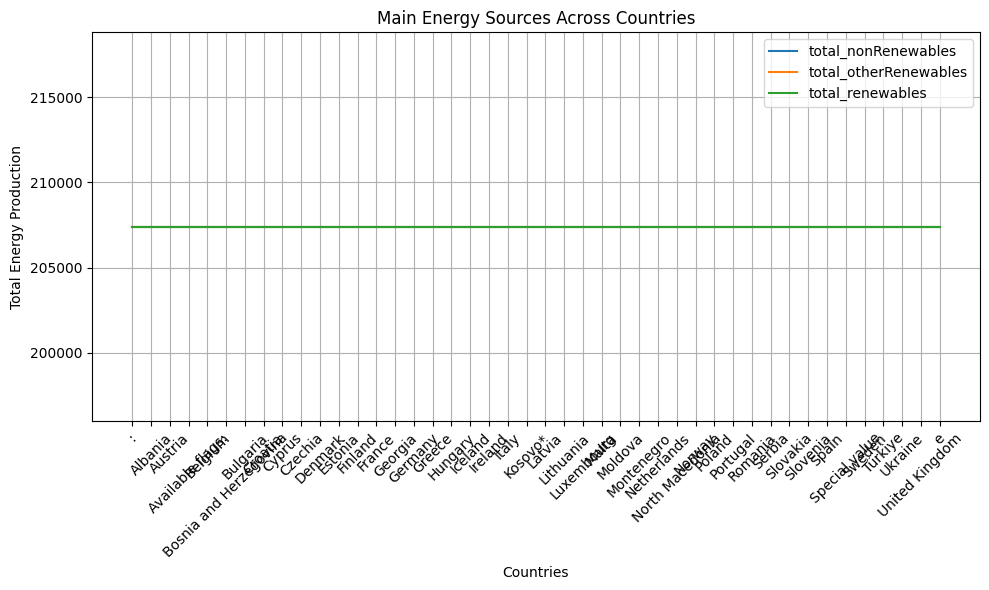

In [74]:
# Plot for mainEnergySources
plot_energy_data_by_month(
    db_path=db_path,
    table_name='mainEnergySources',
    title='Main Energy Sources Across Countries'
)

In [ ]:
# Plot for renewableEnergySources
plot_energy_data(
    db_path=db_path,
    table_name='renewableEnergySources',
    columns_to_plot=['total_geothermal', 'total_hydro', 'total_solar', 'total_wind'],
    title='Renewable Energy Sources Over Time'
)

In [ ]:
# Plot for nonRenewableEnergySources
plot_energy_data(
    db_path=db_path,
    table_name='nonRenewableEnergySources',
    columns_to_plot=['total_coal', 'total_naturalGas', 'total_nuclear', 'total_oil'],
    title='Non-Renewable Energy Sources Over Time'
)